# Apply `scanpy` to flow object

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import joypy

In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', pd.errors.PerformanceWarning)

In [3]:
adata =sc.read_h5ad('8_color_data_set.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 859431 × 15
    obs: 'sample_id'
    uns: 'gate_hierarchy', 'transforms'
    obsm: 'gate_index'
    varm: 'stats'

In [5]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=75, facecolor='white')
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


## Preprocessing

In [6]:
adata.var_names

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'TNFa FITC FLR-A',
       'CD8 PerCP-Cy55 FLR-A', 'IL2 BV421 FLR-A', 'Aqua Amine FLR-A',
       'IFNg APC FLR-A', 'CD3 APC-H7 FLR-A', 'CD107a PE FLR-A',
       'CD4 PE-Cy7 FLR-A', 'Time'],
      dtype='object')

In [7]:
exclude = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time']

Only keep fluroescence intensity markers

In [8]:
data = adata[:, ~adata.var_names.isin(exclude)]

normalizing counts per cell
    finished (0:00:00)


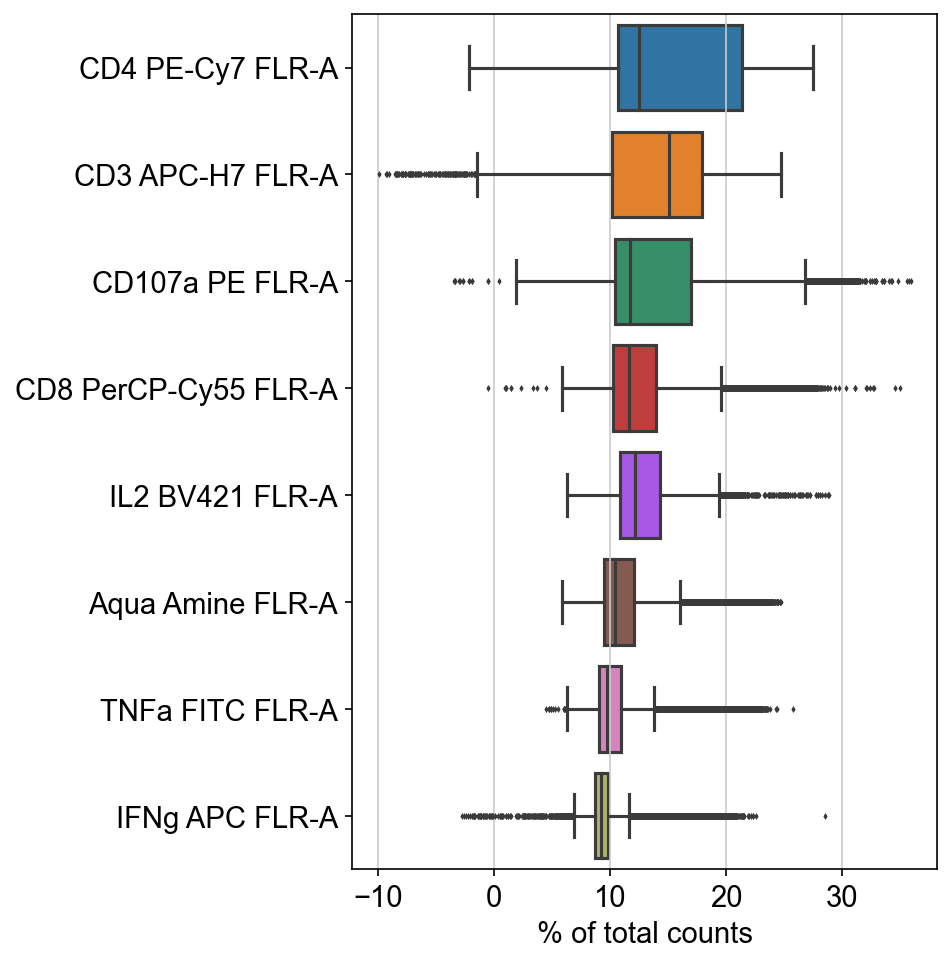

In [9]:
sc.pl.highest_expr_genes(data)

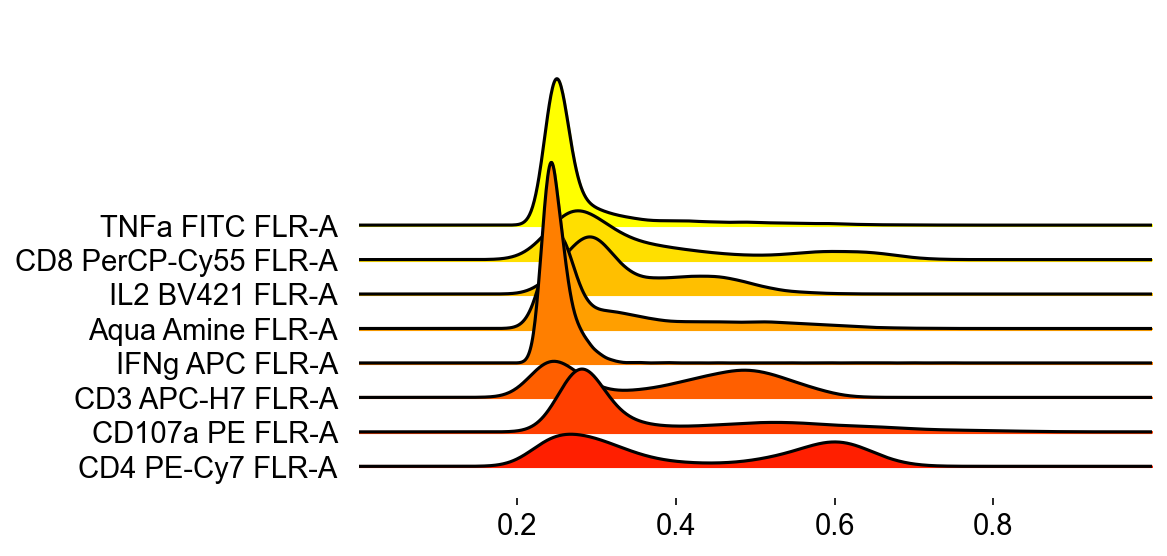

In [10]:
joypy.joyplot(data.to_df().sample(10_000),
              figsize=(8,4),
              x_range=[0, 1],
              colormap=plt.cm.autumn_r, 
              overlap=1.5)
pass

## Principal component analysis

In [11]:
sc.tl.pca(data)

computing PCA
    with n_comps=7
    finished (0:00:00)


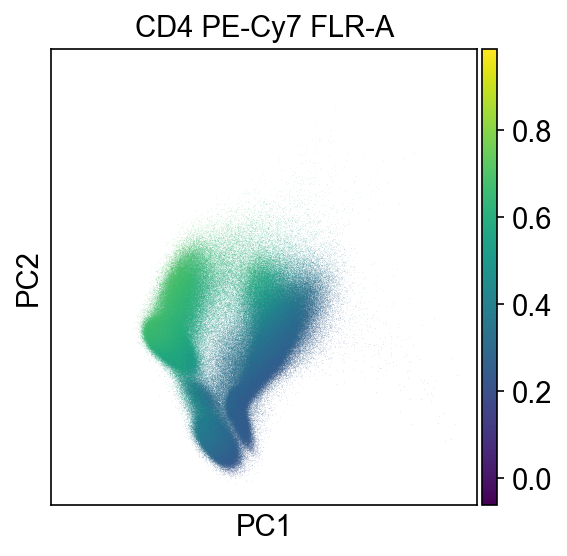

In [12]:
sc.pl.pca(data, color='CD4 PE-Cy7 FLR-A')

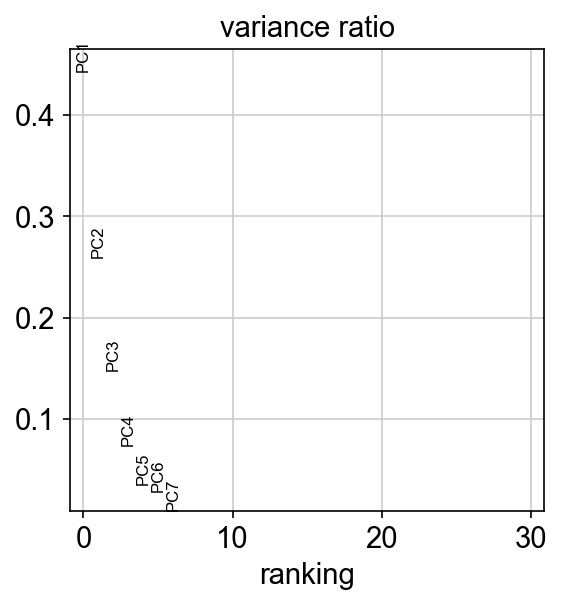

In [13]:
sc.pl.pca_variance_ratio(data, log=False)

## Computing the neighborhood graph


To speed up UMAP calculations,
```
pip install pynndescent
```

Subsample to speed things up

In [14]:
sc.pp.subsample(data, n_obs=50_000)

In [15]:
%%time
sc.pp.neighbors(data, n_neighbors=10, n_pcs=0)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
CPU times: user 11.3 s, sys: 271 ms, total: 11.6 s
Wall time: 9.69 s


In [16]:
%%time
sc.tl.leiden(data, resolution=0.1)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
CPU times: user 2.34 s, sys: 57.4 ms, total: 2.4 s
Wall time: 2.39 s


By quantifying the connectivity of partitions (groups, clusters) of the
single-cell graph, partition-based graph abstraction (PAGA) generates a much
simpler abstracted graph (*PAGA graph*) of partitions, in which edge weights
represent confidence in the presence of connections. By tresholding this
confidence in :func:`~scanpy.pl.paga`, a much simpler representation of the
manifold data is obtained, which is nonetheless faithful to the topology of
the manifold.

In [17]:
%%time
sc.tl.paga(data)

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
CPU times: user 633 ms, sys: 20.2 ms, total: 653 ms
Wall time: 652 ms


--> added 'pos', the PAGA positions (adata.uns['paga'])


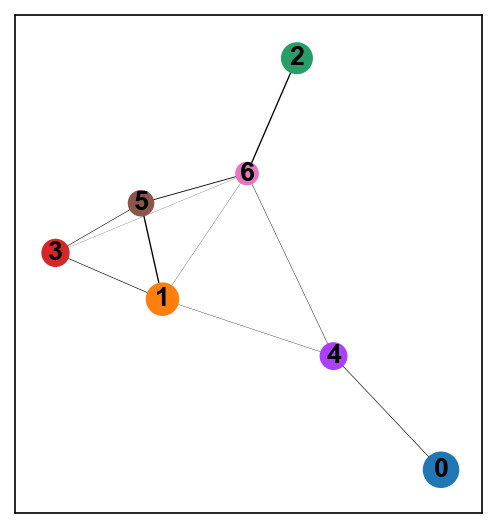

CPU times: user 145 ms, sys: 43.8 ms, total: 188 ms
Wall time: 91.4 ms


In [18]:
%%time
sc.pl.paga(data)

In [19]:
%%time
sc.tl.umap(data, init_pos='paga')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)
CPU times: user 21 s, sys: 226 ms, total: 21.2 s
Wall time: 20.7 s


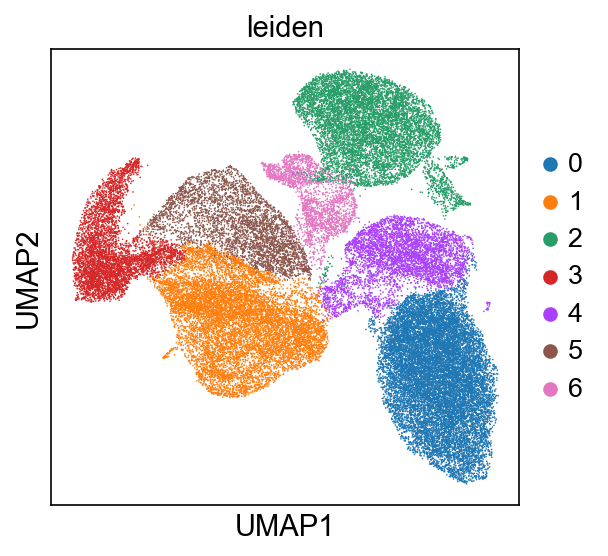

CPU times: user 777 ms, sys: 227 ms, total: 1 s
Wall time: 313 ms


In [20]:
%%time
sc.pl.umap(data, color=['leiden'])

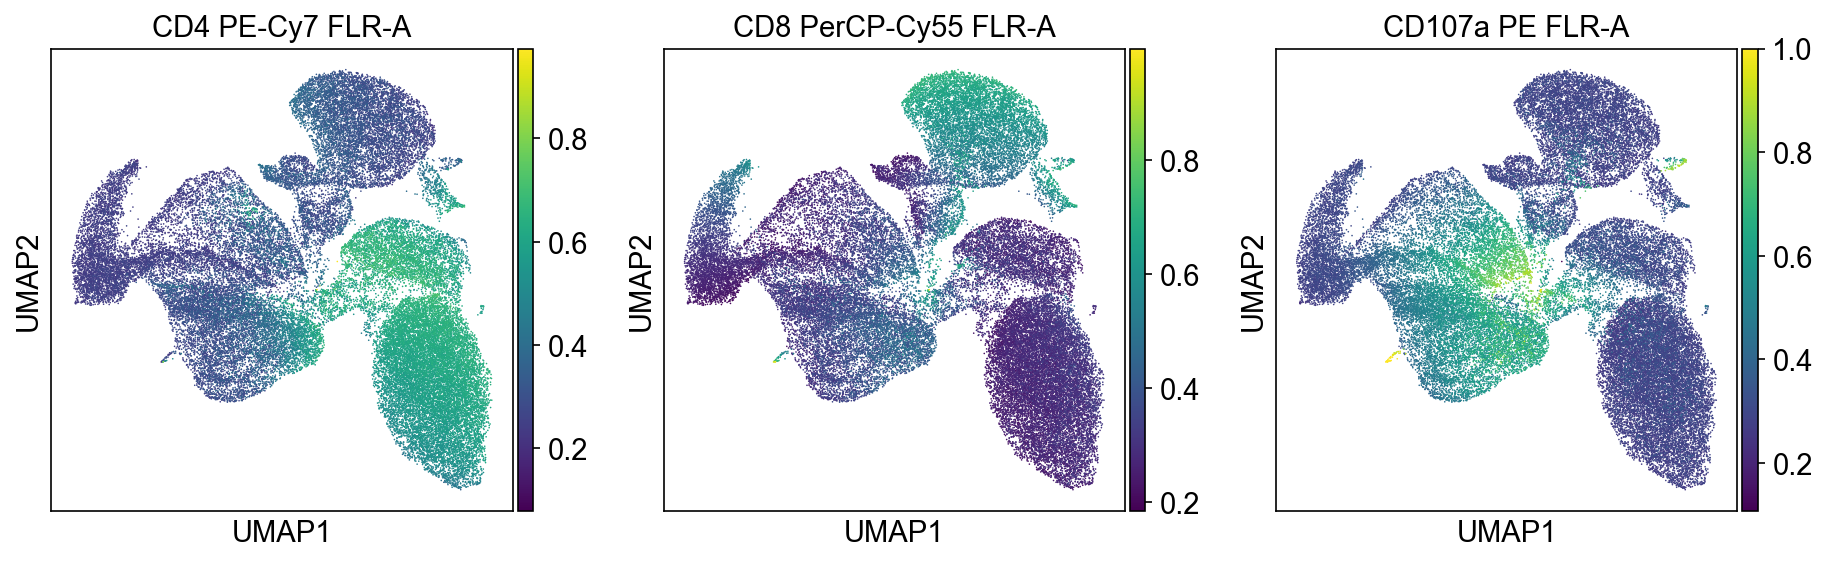

CPU times: user 1.1 s, sys: 239 ms, total: 1.34 s
Wall time: 604 ms


In [21]:
%%time
sc.pl.umap(data, color=['CD4 PE-Cy7 FLR-A', 'CD8 PerCP-Cy55 FLR-A', 'CD107a PE FLR-A'])

## Finding markers

In [22]:
sc.tl.rank_genes_groups(
    data,
    groupby='leiden',
    method='wilcoxon'
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


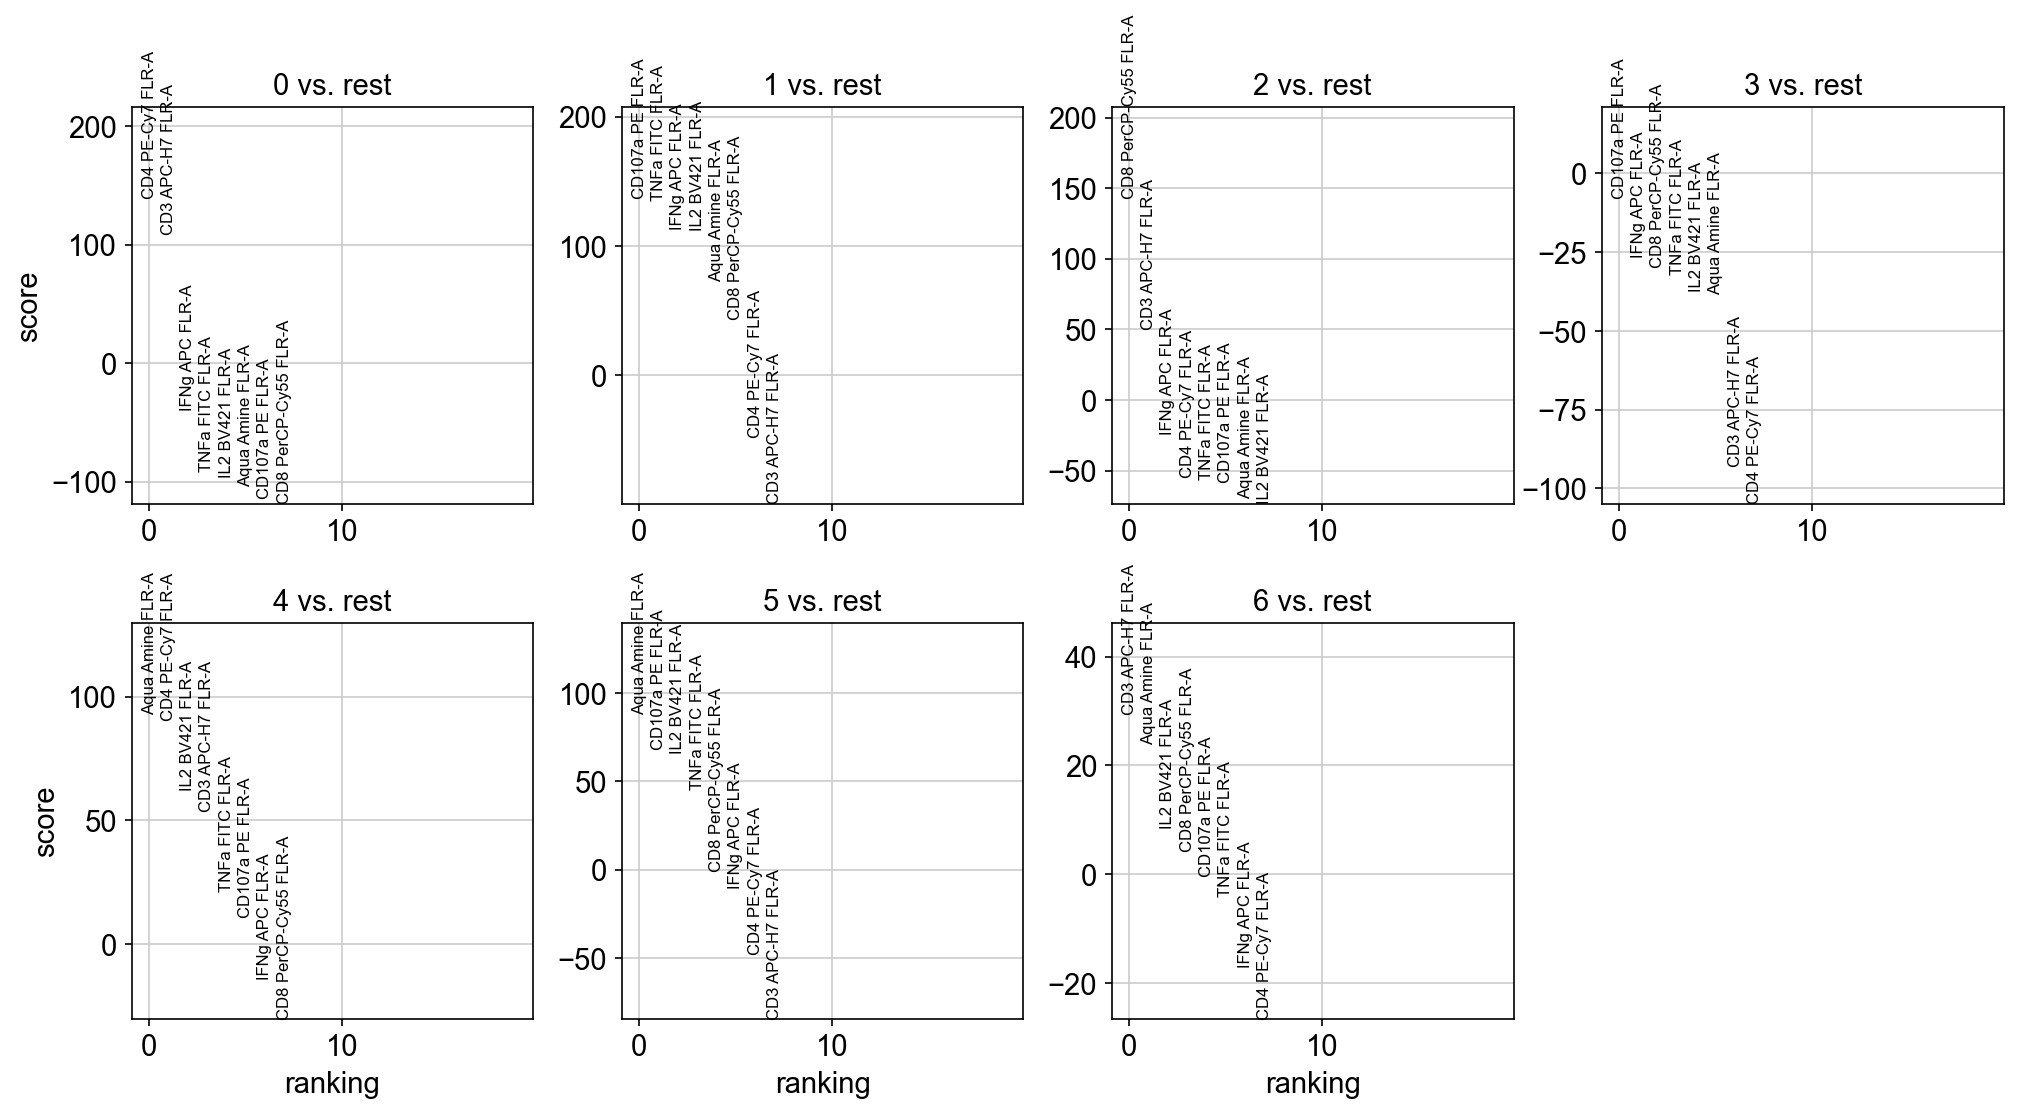

In [23]:
sc.pl.rank_genes_groups(
    data,
    sharey=False
)

In [24]:
markers = list(set(data.var_names) - set(exclude))

In [25]:
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6
0,CD4 PE-Cy7 FLR-A,CD107a PE FLR-A,CD8 PerCP-Cy55 FLR-A,CD107a PE FLR-A,Aqua Amine FLR-A,Aqua Amine FLR-A,CD3 APC-H7 FLR-A
1,CD3 APC-H7 FLR-A,TNFa FITC FLR-A,CD3 APC-H7 FLR-A,IFNg APC FLR-A,CD4 PE-Cy7 FLR-A,CD107a PE FLR-A,Aqua Amine FLR-A
2,IFNg APC FLR-A,IFNg APC FLR-A,IFNg APC FLR-A,CD8 PerCP-Cy55 FLR-A,IL2 BV421 FLR-A,IL2 BV421 FLR-A,IL2 BV421 FLR-A
3,TNFa FITC FLR-A,IL2 BV421 FLR-A,CD4 PE-Cy7 FLR-A,TNFa FITC FLR-A,CD3 APC-H7 FLR-A,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A
4,IL2 BV421 FLR-A,Aqua Amine FLR-A,TNFa FITC FLR-A,IL2 BV421 FLR-A,TNFa FITC FLR-A,CD8 PerCP-Cy55 FLR-A,CD107a PE FLR-A


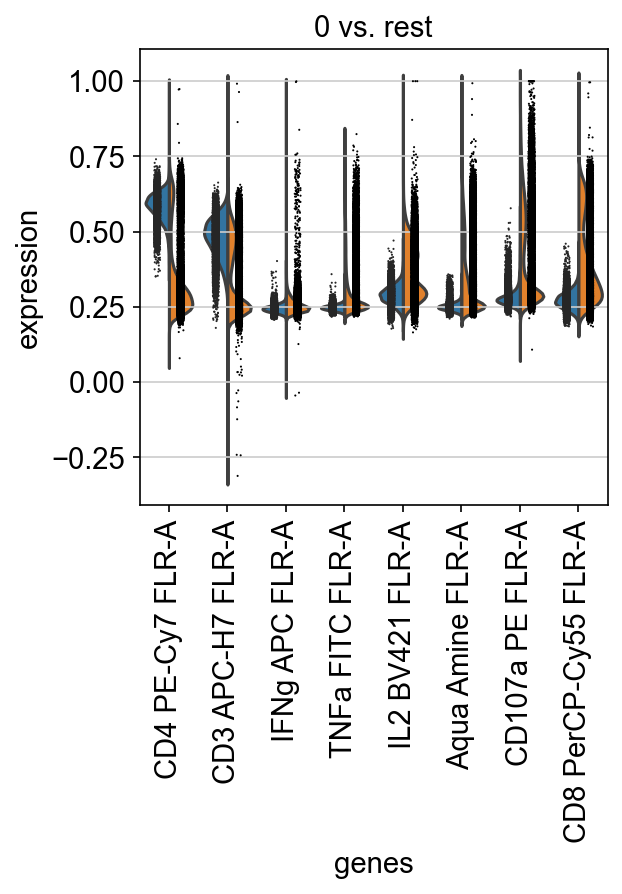

In [26]:
sc.pl.rank_genes_groups_violin(data, groups='0')

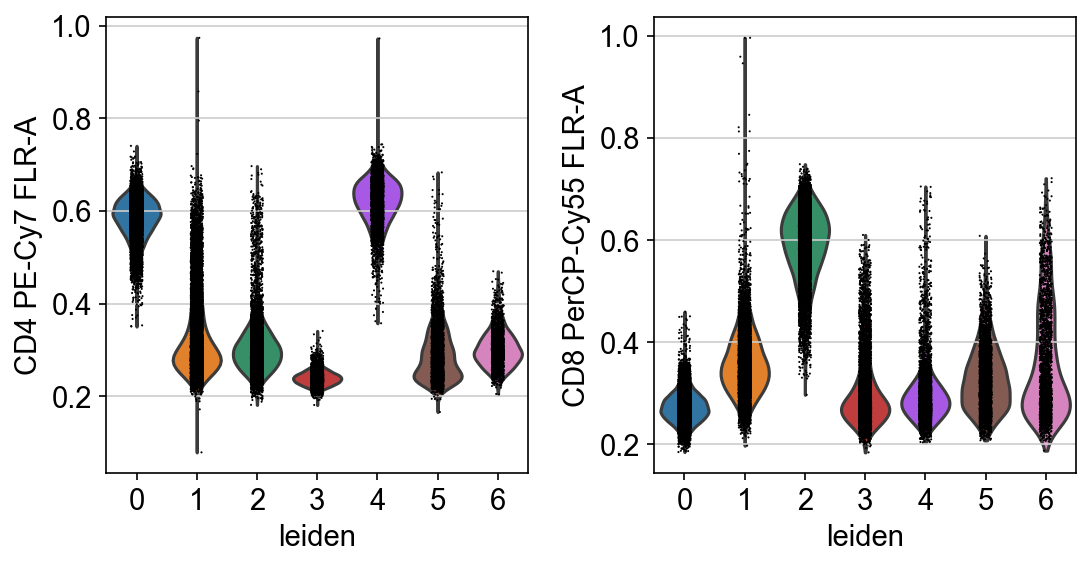

In [27]:
sc.pl.violin(data, ['CD4 PE-Cy7 FLR-A', 'CD8 PerCP-Cy55 FLR-A'], groupby='leiden')

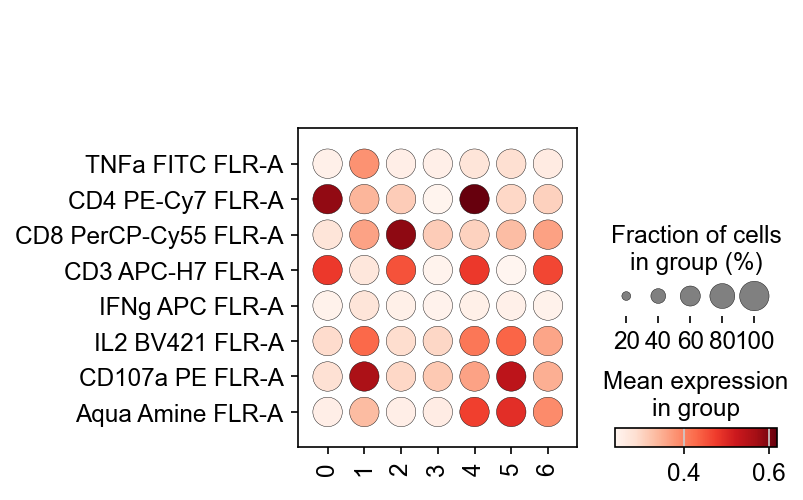

In [28]:
sc.pl.dotplot(data, markers, groupby='leiden', swap_axes=True)

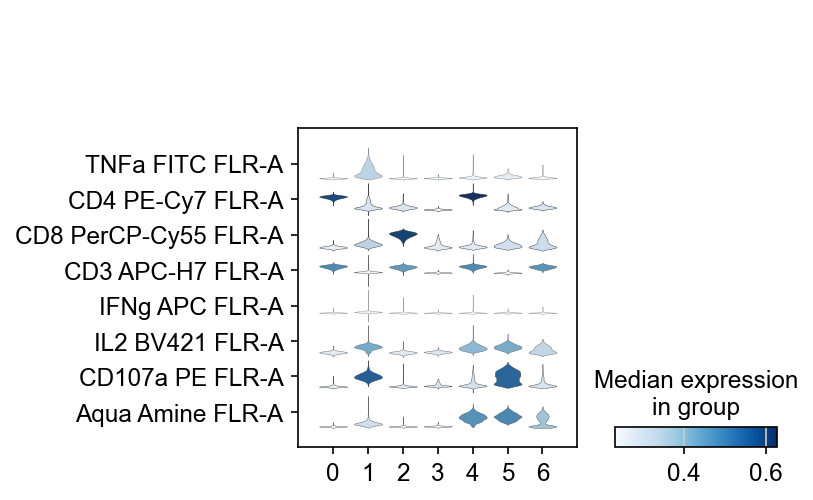

In [29]:
sc.pl.stacked_violin(data, markers, groupby='leiden', rotation=90, swap_axes=True)

In [30]:
results_file = '8_color_ICS.h5ad'

In [31]:
data.write(results_file, compression='gzip')

## More visualizations

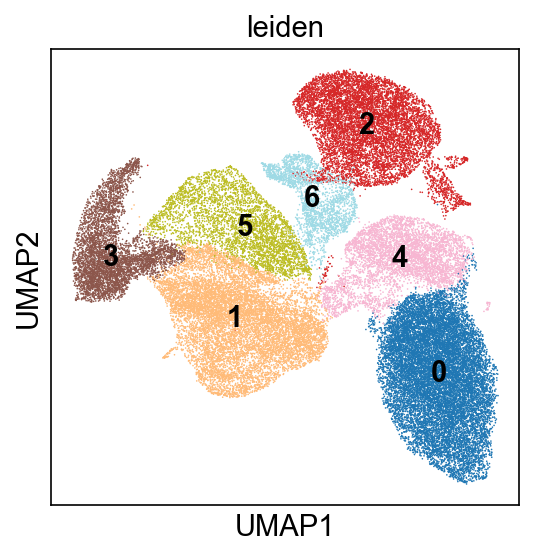

In [32]:
sc.pl.umap(
    data, 
    color='leiden',
    add_outline=False,
    legend_loc='on data',
    palette='tab20'
)

In [33]:
sc.tl.dendrogram(data, groupby='leiden')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [34]:
sc.pl.dotplot?

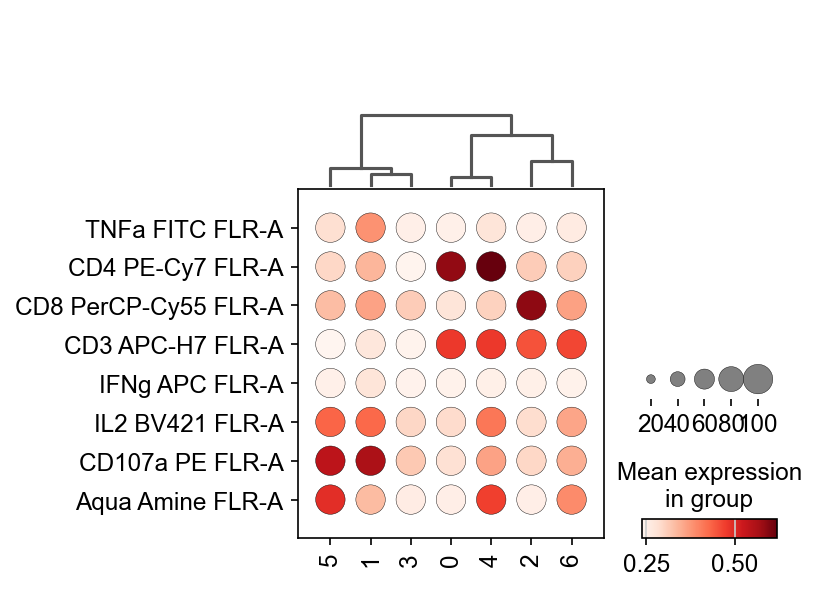

In [35]:
sc.pl.dotplot(
    data,
    markers,
    groupby='leiden',
    dendrogram=True,
    swap_axes=True,
    size_title=None
)

In [36]:
sc.pl.matrixplot?

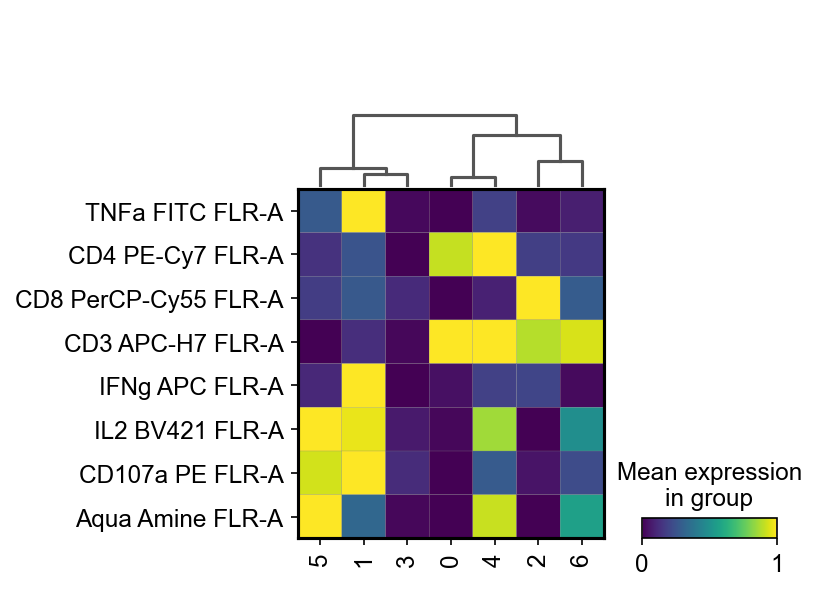

In [37]:
sc.pl.matrixplot(
    data,
    markers, 
    groupby='leiden',
    swap_axes=True,
    standard_scale='var', 
    log=False,
    dendrogram=True,
)

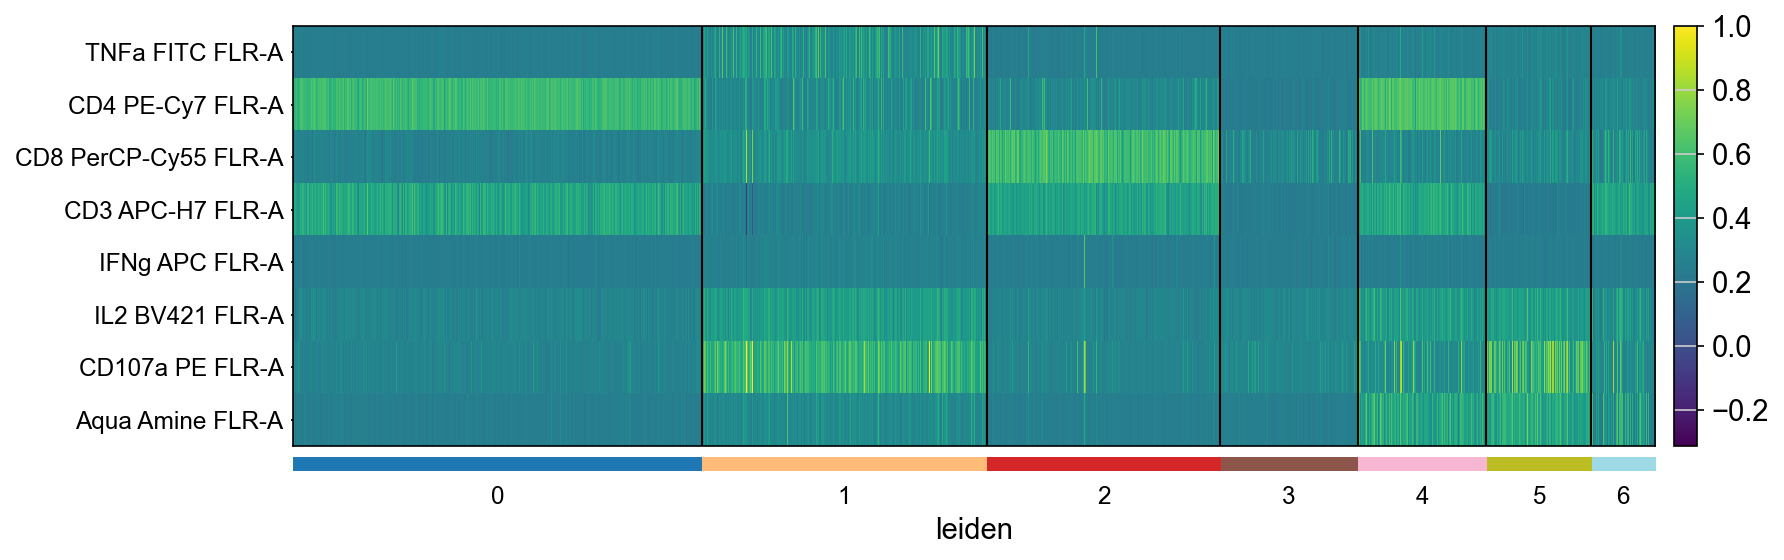

In [38]:
sc.pl.heatmap(
    data,
    markers,
    groupby='leiden',
    swap_axes=True,
    figsize=(12,4)
)

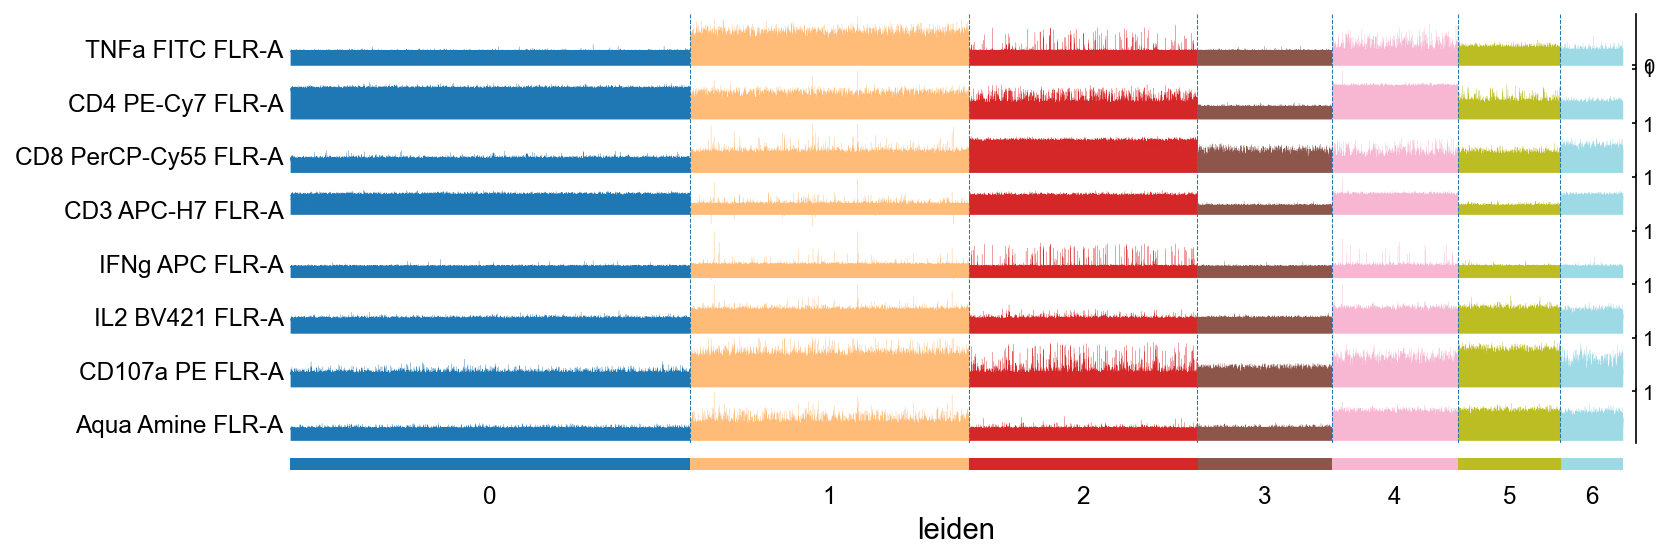

In [39]:
sc.pl.tracksplot(
    data,
    markers,
    groupby='leiden',
    swap_axes=True,
    figsize=(12,4)
)

In [40]:
data.layers['scaled'] = sc.pp.scale(data, copy=True).X

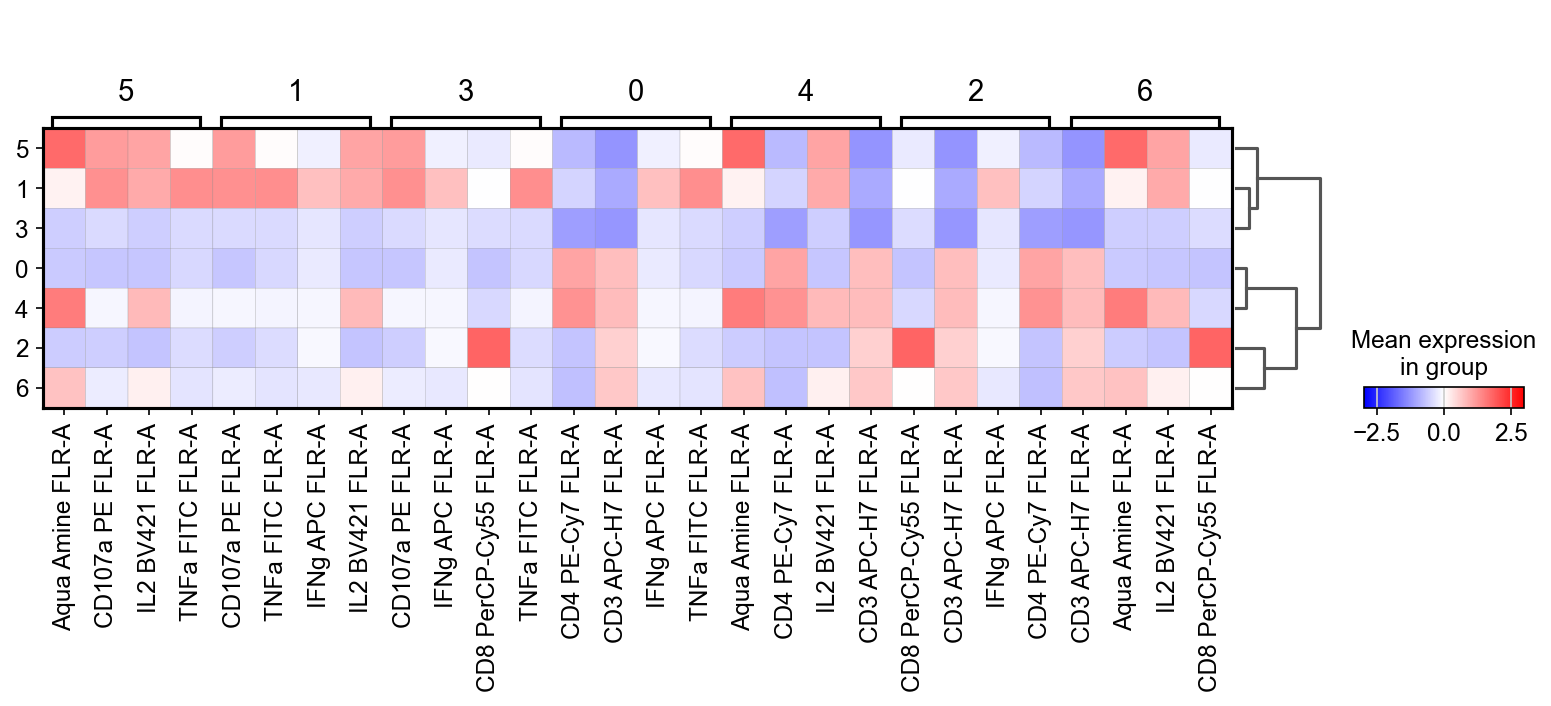

In [41]:
sc.pl.rank_genes_groups_matrixplot(
    data, 
    n_genes=4, 
    use_raw=False, 
    vmin=-3,
    vmax=3,
    cmap='bwr',
    layer='scaled'
)

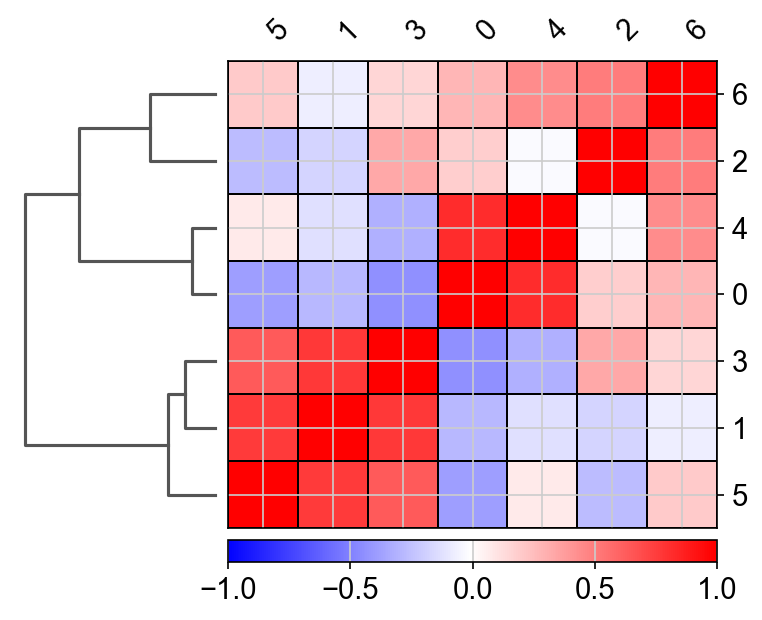

In [42]:
sc.pl.correlation_matrix(
    data,
    groupby='leiden',
)


In [44]:
sc.tl.embedding_density(
    data,
    groupby='leiden'
)

computing density on 'umap'
--> added
    'umap_density_leiden', densities (adata.obs)
    'umap_density_leiden_params', parameter (adata.uns)


In [46]:
sc.pl.embedding_density?

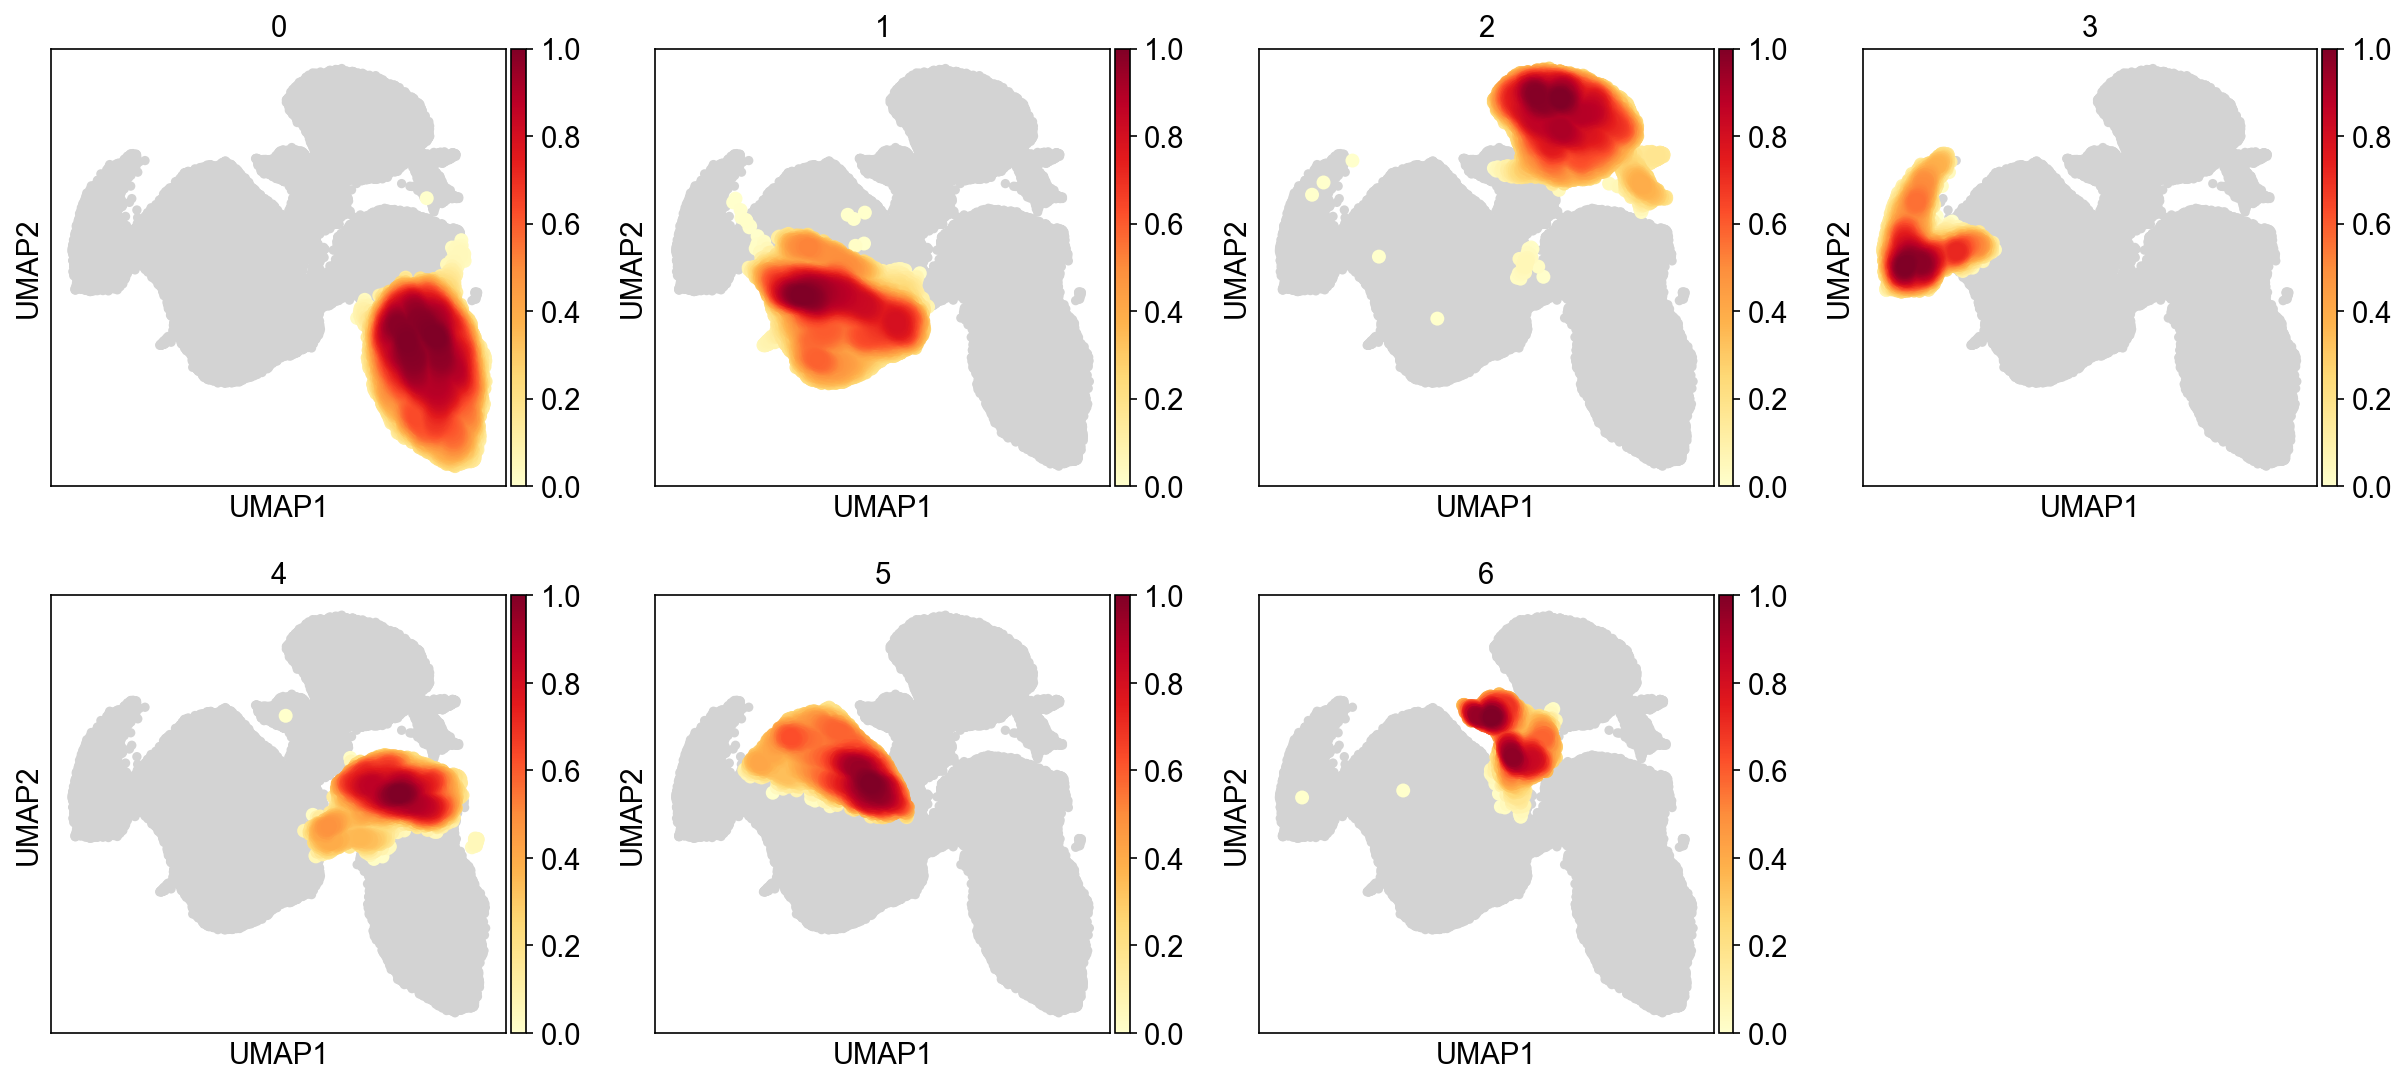

In [45]:
sc.pl.embedding_density(
    data,
    groupby='leiden'
)